# Simpsons Character Images
---
## Visualizing variance in high dimensional space using Principle Component Analysis, and then explaining this variance with a deep convolutional neural network. 

## Contents

1. Introduction
2. Packages
3. Data preview
4. Visualizing regions of high variance
5. A convolutional neural network for predicting the character

---



## 1. Introduction

In this notebook, I use the fantastic [Simposons Character Dataset](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset), generously annotated and shared by [Alexandre Attia
](https://www.kaggle.com/alexattia), to do some neat computer vision work. 

Specifically, in this notebook I cover how to:

1. Load and process images using the `Pillow` library
2. Create a neat visualization of the variation amongst the pictures using Principle Component Analysis (PCA)
3. Build a deep convolutional neural network using the `Keras` framework, including how to learn powerful models on relatively small data, how to perform efficient cross validation, etc. 

This script includes some very expensive operations (image data is big), and so if you plan on running these commands, expect them to take all night. I would love feedback on how to make these operations more efficient!

### 2. Packages

For deep learning problems, I use the `Keras` framework. It provides a  simple API to build complex models, and great toold for model tuning, data processing, and validation (as we'll see)

For general machine learning pre-proccing tasks, such as creating training/developement/test data splits and converting categorical labels to one-hot encodings, I use `sklearn`. 

For image loading and transfomations, I use the `Pillow` package. 

In [84]:
# navigating the file system
import os
import glob

# store paths to all images
paths = glob.glob('data/simpsons_dataset/*/*')

# data manipulation
import numpy as np
import pandas as pd

# plotting images
import matplotlib.pyplot as plt
%matplotlib inline

# Tools for setting up machine learning experiments
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Principle component analysis
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

# Deep learning stuff!
from keras.preprocessing.image import img_to_array
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import save_model
from keras.utils import to_categorical
from keras.optimizers import rmsprop
from keras.models import load_model


# image processing using Pillow
from PIL import Image

# load and save objects to/from dis
import pickle as pkl

## 3. Data preview

This dataset consists on 20,000+ labeled images of over 25 simpsons characters. Their sizes and dimensions vary, though they are all `RGB` format `.jpeg` files. 

Here's a sample image:

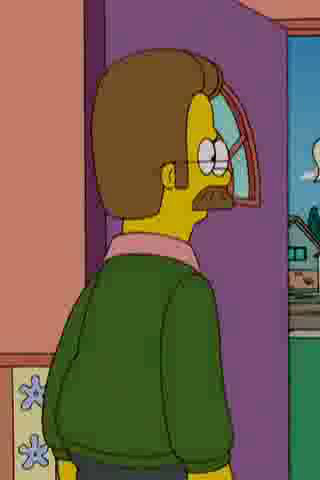

In [249]:
# randomly select an image
np.random.seed(4)
im1 = Image.open(np.random.choice(paths, size=1)[0])
im1

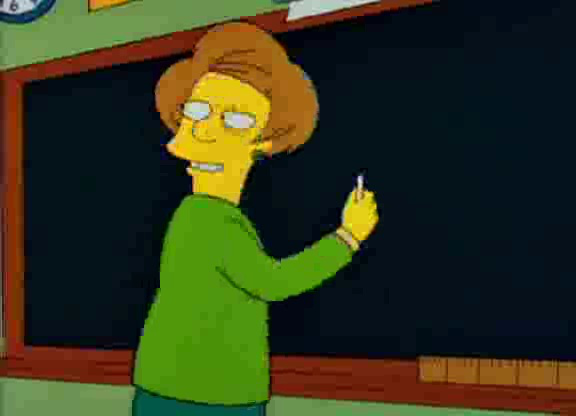

In [109]:
# randomly select a second image
np.random.seed(3)
im2 = Image.open(np.random.choice(paths, size=1)[0])
im2

As you can see, the images have different sizes, and dimension. Further, the characters are not all located in the same relative position in the images - and they do not all "face the camera," so to speak. These factors makes it difficult to build effective classifiers on this data. 

In orrder to work with this data, I'll need to standardize the sizes of the images. As a form of lossy compression, I'll resize the images in this dataset to 128 by 128 pixels in size. 

This is a "quick and dirty" strategy for data normalization - as it is a form of lossy compression, and distorts the dimensions of images which are not square. 

Here's a sample of what 25 compressed images look like:

In [20]:
# all images will by 128x128 pixels 
size_x, size_y = 128,128
# set seed for reproducability
np.random.seed(1996)
# pick 35 random images
sample_paths = np.random.choice(paths, size = 25, replace=False)
# load, resize and store said images in a list
sample_images = [Image.open(pth).resize((size_x, size_y)) for pth in sample_paths]

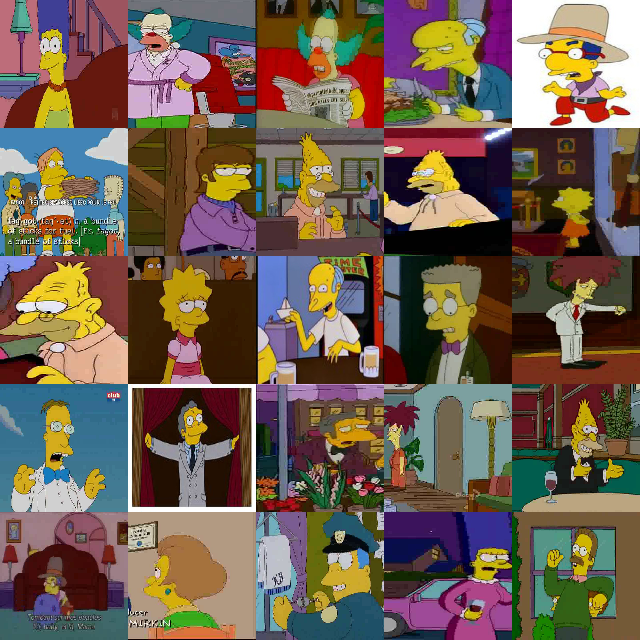

In [3]:
'''
Plot sample of images. 
To do so, past together 5 images at a time to make five rows, 
then paste the five rows together
'''
row1 = Image.fromarray(np.hstack( (np.asarray( i) for i in sample_images[0:5])))
row2 = Image.fromarray(np.hstack( (np.asarray( i) for i in sample_images[5:10])))
row3 = Image.fromarray(np.hstack( (np.asarray( i) for i in sample_images[10:15])))
row4 = Image.fromarray(np.hstack( (np.asarray( i) for i in sample_images[15:20])))
row5 = Image.fromarray(np.hstack( (np.asarray( i) for i in sample_images[20:25])))
# paste these rows together vertically
Image.fromarray(np.vstack((np.asarray(i) for i in [row1,row2,row3,row4,row5])))


---

## 4. Visualizing regions of high variance

Principle component analysis (PCA) is a common teqnique used to project data a high dimensional space to a lower dimension, with the smallest loss in variation in the data. This process is a form of lossy compression, but by preserving as much variation as possible, it is (roughly speaking) the "least lossy compression" from the high dimensional space to the lower dimensional space.

A quick aside on how this works: say we're trying to convert a design matrix $X \in \mathbb{R}^{n*p}$ to a lower dimension $\mathbb{R}^{n*m} \quad m \le p$. This is equivalent to projecting each vector $x_i \in \mathbb{R}^p$, which toegether define $X$, to $\mathbb{R}^m$.

By the magic of linear algebra, it turns out that if we take the eigen-decomposition of the variance-covariance matrix of $X$, the resulting eigenvectors are the _principle components_ of $X$ - which means that these vectors are a bases along which $X$ varies the most. Furthermore, the eigenvectors associated with this decomposition are the percentage of variance in $X$ explained by that basis (very roughly speaking). 

And so, if we want to project $X \in \mathbb{R}^{n*p}$ to $X' \in \mathbb{R}^{n*m}$, we can take the $m$ eigenvectors with the highest corresponding eigenvalues, and let them form a change of basis matrix $E$. Then, when we apply this change of basis tranformation to $X$ ($EX$), we get a new dataset $X' \in \mathbb{R}^{n*m}$ which preserves as much of the variation in $X$ as possible. That's PCA!

---

Now, in this section, I use PCA to form a neat visual, inspired by [this great notebook.](https://www.kaggle.com/arthurtok/interactive-intro-to-dimensionality-reduction). The idea is to convert each image to a vector (by unrolling the pixel intensities), stacking them into a matrix, an them performing PCA. By looking at the bases (eigenvectors) which explain the most variation, we can see which regions of the images have the most variation.


To do so, I'll need to load all the images, resize them, and stack them into a vector. I also convert the images to black and white for further compression, and so that the eigenvectors still have visual meaning.

In [2]:
# set the sizes for the x and y axes of image
x_size, y_size = 128, 128
# create an array to store a list of all characters
all_characters = np.ndarray(shape = (0,))
# create a template for X and y
X = np.ndarray(shape = (0,x_size*y_size))
y = np.ndarray(shape = (0,))

In [3]:
for path in paths:
    # isolate the character's name from the path
    character = path.split('/')[-2]
    # add said character name to the target vector
    all_characters = np.append(all_characters, character)

Looking at the number of times each character appears in the dataset:

In [4]:
# look at the number of photos of each character
counts = np.unique(all_characters,return_counts = True)
char_count= sorted(zip(counts[0], counts[1]), key = lambda x: x[1], reverse = True)
char_count

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 ('gil', 27),
 ('miss_hoover'

We an see that after the 20th most common character, the data becomes rather sparse for the remaining characters. In the interest of making the class sizes roughly on the same scale, I'm only going to keep the 20 most commonly occuring characters to work with from this point forward.

In [5]:
# keep a list of only the 20 most commonly occuring characters
top_characters = [character[0] for character in char_count[0:20]]
top_characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten',
 'chief_wiggum',
 'abraham_grampa_simpson',
 'sideshow_bob',
 'apu_nahasapeemapetilon',
 'kent_brockman',
 'comic_book_guy',
 'edna_krabappel',
 'nelson_muntz',
 'lenny_leonard',
 'mayor_quimby']

In [61]:
"""
For each image, do:

    1. Check that the character is part of top 20 characters
    2. If so, open the image, convert to gray scale, and resize to 128x128 pixels
    3. Unroll the image to a single vector, and add to design matrix `X`.
    4. Add character label to `y`.
"""
for path in paths:
    # isolate the character's name from the path
    character = path.split('/')[-2]
    if character in top_characters:
        # Open the current image
        img = Image.open(path)
        # gray scale the image
        img = img.convert("L")
        # reshape the image
        img = img.resize((x_size, y_size))
        # flatten the image into a vector
        img_vect = np.array([list(img.getdata())])
        # add the vector to the design matrix
        X = np.concatenate((X, img_vect))
        # add the label to the target vector
        y = np.append(y, character)

In [62]:
print(X.shape)
print(y.shape)

(19548, 16384)
(19548,)


In [64]:
# save the arrays
np.save(file="X.npy", arr=X)
np.save(file="y.npy", arr=y)

---

Now that we have a matrix $X$ which stores all the images, we can perform principle compoent analysi on it. 

I will project each vector $x^{(i)} \in \mathbb{R}^{16384} \text{  to  }\mathbb{R}^{30}$. Then, visualizing the top 30 principle components, we can get an idea of where the variation is coming from. 

In [73]:
# Dimension to which we want to project
n_components = 30
pca = PCA(n_components=n_components).fit(X)

eigenvalues = pca.components_.reshape(n_components, 128, 128)

# Extracting the PCA components ( eignevalues )
eigenvalues = pca.components_

Now, we can sort these principle compenents in terms of how much variation they explain, and then plot their intensities:

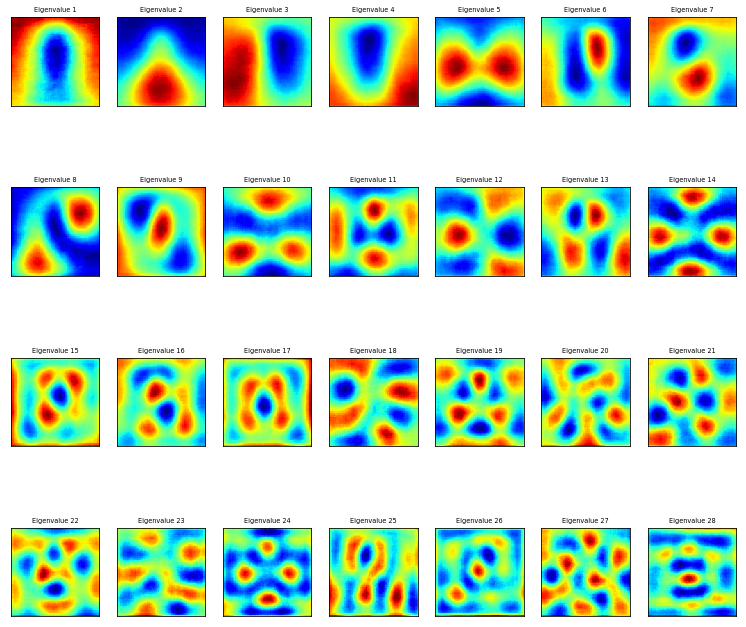

In [75]:
n_row = 4
n_col = 7

# Plot the first 8 eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
#     for offset in [10, 30,0]:
#     plt.subplot(n_row, n_col, i + 1)
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(128,128), cmap='jet')
    title_text = 'Eigenvector ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()


##### Isn't that cool?

The first principle component vaguely looks like the silhouette of a person - with the highest variance in towards the background. This makes sense, since these are all images of faces - but the backgrounds are different for nearly every picture. 

The sencond, third and fourth principle components account for the variation in the middle, left and right parts of the images. As we progress to principle components that explain less and less of the variance, we can see that the eigenvectors correspond to more complex regions. These charts become uninterpretable past the fourth or fifth eigenvector, but I think it's really cool, and pretty.

---

## 5. A convolutional neural network for predicting the character


Now onto something a bit more practical - building a convolutional neural network using `Keras`. In this section , I will show how to:

1. Define a ConvNet model using the `Sequential` API
2. Use the `ImageDataGenerator` class to artificially grow our training data
3. Perform early stopping during training using the `EarlyStopping` class

First, I'll need to re-load the data. When creating the PCA visualziation above, I resized each image and converted them to a gray-scale. Now, I will still resize each image to 128x128 pixels, but I will keep them in RGB format.

In [68]:
"""
Read all the images, and resize them to 128x128 sized RGB images. 
Aggreage them in a list called `data`
"""
# aggretate the images, and the labels
data, labels = [], []

X_SIZE, Y_SIZE = 64, 64

In [69]:
for path in paths:
    # isolate the character's name from the path
    character = path.split('/')[-2]
    if character in top_characters:
        # Open the current image
        img = Image.open(path)
        # reshape the image
        img = img.resize((X_SIZE, Y_SIZE))
        # flatten the image to a vector, and add to data 
        img = img_to_array(img)
        data.append(img)
        # add the character label to the label list
        labels.append(character)

In [70]:
# convert data and labels to numpy arrays, and re-scale to speed up training
data = np.array(data)
labels = np.array(labels)

---

Now - when training - I'm going to have to convert the response categories to an encoding that a neural network can understand - namely _one-hot encoding_. Using `sklearn`'s `LabelEncoder` class and some utilities from `Keras`, these two functions encode the character names into one-hot encoding, and deconde one-hot encodings back to character names - respectively.

In [41]:
# train an encoder to convert labels to integer labels, one-hot encodings, and back
encoder = LabelEncoder().fit(labels)

def encode_onehot(lab):
    return to_categorical(encoder.transform(lab))

def decode_onehot(lab):
    return encoder.inverse_transform(np.argmax(lab, axis = 1))


Now, for the purpose experimentation, I will split my data into a 60:20:20 training:validation:test split:

In [72]:
'''
split data into train, developement (validation), and test splits
'''
# isolate the test set, and keep the rest for training and validation
X_train_and_dev, X_test, y_train_and_dev, y_test = train_test_split(data, \
                 labels, test_size=0.2, random_state=1)
# Further split the training/dev sets into seperate training and dev sets. 
X_train, X_dev, y_train, y_dev = train_test_split(X_train_and_dev, \
                 y_train_and_dev, test_size=0.25, random_state=1)

In [12]:
# sanity check: do the sizes make sense? 
print("Number of examples in dataset: %d" % len(data))
print("Number of examples in training set: %d" % len(X_train))
print("Number of examples in devopement set: %d" % len(X_dev))
print("Number of examples in test set: %d" % len(X_test))

Number of examples in dataset: 19548
Number of examples in training set: 11728
Number of examples in devopement set: 3910
Number of examples in test set: 3910


---

Now, I wrap the archetecture of the convolutional neural network into a class called `LeNet`. This is just for the sake of preserving a namespace for each iteration of the model.

In [53]:
class LeNet:
    @staticmethod
    def build(width, height, depth, classes = 20):
        # initialize the model
        model = Sequential()
        input_shape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
            
        # add first convolutional and max pooling layers
        model.add(Conv2D(32, (5,5),input_shape = input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # add second convolutional and max pooling layers
        model.add(Conv2D(32, (5,5)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # add third convolutional and max pooling layers
        model.add(Conv2D(64, (5,5)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation('softmax'))

        model.compile(loss='categorical_crossentropy',
                      optimizer= rmsprop(lr=0.0001, decay=1e-6),
                      metrics=['accuracy'])
        
        return model

---

Now, I use the `ImageDataGenerator` class from `keras.preprocessing.image` to "augment" our dataset. This generator performs a series of random manipulations to each image in our training data. 

Thus, we can convert our training set of around 15,000 images to one that's much larger, without causing our model to overfit to our training data. Furthermore, this will help our model learn some of the distortions I've applied to the images when I resize them to 128x128 pixels. 

Below I initialize a `ImageDataGenerator` class, and apply  it to one sample image to show how it works.

In [28]:
# construct the image generator for data augmentation
img_gen = img_gen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)

This `ImageDataGenerator` repeatedly performs random mutations to each picture to augment the ddataset. The mutations it applies include:

- rotation
- compression/expansion of width/height
- shear
- zoom
- flip horizontally

The generator must be fit to our training data. We can look at a sample image, and see some of the transformatinons the generator may apply to it:

In [29]:
# fit the generator
img_gen.fit(X_train)

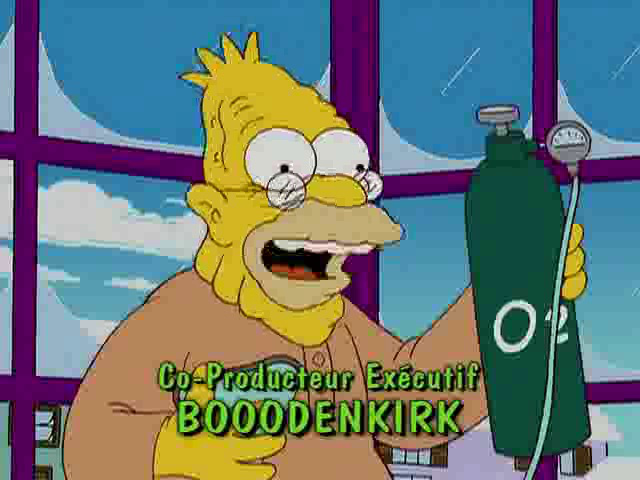

In [16]:
#sample image - to show how image agumentor makes new training data from the old
sample_image = Image.open(paths[14])
sample_image

In [30]:
# convert the image to an array - this is the format that the ImageDataGenerator expects
sample_image_asarray = img_to_array(sample_image)
sample_image_asarray = sample_image_asarray.reshape((1,) + sample_image_asarray.shape)

In [31]:
'''
For this sample image, apply the generator to create 20 random mutated versions.
Store these images in a folder called `preview`. 
'''
if not os.path.isdir("preview"):
    os.mkdir("preview")

# Write the 
i = 0
for batch in img_gen.flow(sample_image_asarray, batch_size=1,
                      save_to_dir='preview', save_prefix='grandpa_tranformed', save_format='jpeg'):
    i += 1
    if i > 20:
        break

In [32]:
# open the images of the distortions
grandpa_images = [Image.open(pth).resize((size_x, size_y)) for pth in glob.glob("preview/*")]

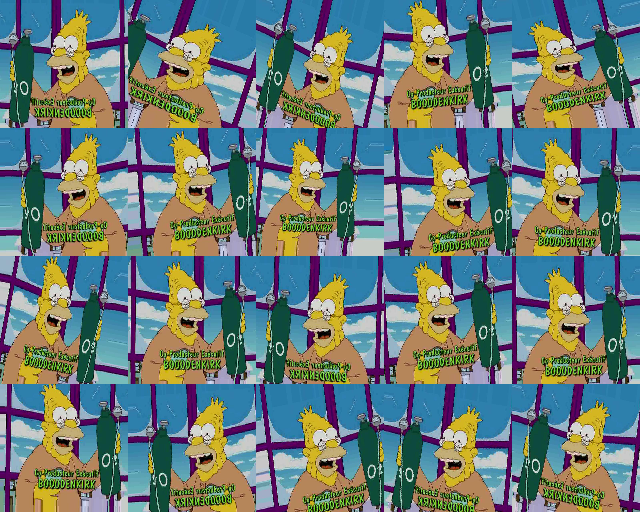

In [33]:
'''
Plot sample of images. 
To do so, past together 5 images at a time to make five rows, 
then paste the five rows together
'''
row1 = Image.fromarray(np.hstack( (np.asarray( i) for i in grandpa_images[0:5])))
row2 = Image.fromarray(np.hstack( (np.asarray( i) for i in grandpa_images[5:10])))
row3 = Image.fromarray(np.hstack( (np.asarray( i) for i in grandpa_images[10:15])))
row4 = Image.fromarray(np.hstack( (np.asarray( i) for i in grandpa_images[15:20])))
# paste these rows together vertically
Image.fromarray(np.vstack((np.asarray(i) for i in [row1,row2,row3,row4])))

As you can see, the `ImageDataGenerator` has turned one image of Abraham (grandpa) Simposon into 20 - each slightly different to avoid learning idiosyncracies of this particular image (though there is still a risk that the network will do so.) 

---

Now, onto bulding the network. 

Calling the static method `LeNet.build()` to get a model, we can initialize a model and view its archetecuture:

In [57]:
# get a first model
model = LeNet.build(width = X_SIZE, height = Y_SIZE, depth = 3)

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 60, 60, 32)        2432      
_________________________________________________________________
activation_16 (Activation)   (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 32)        25632     
_________________________________________________________________
activation_17 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 64)          51264     
__________

In [45]:
plot_model(model, "baseline.png")

![](baseline.png)

Finally, we can initialize an `EarlyStopping` callback, which will stop training if the validation accuracy has not improved for three consecutive epochs. We can also use the `ModelCheckpoint` callback to save the best model at the end of training:

---

Here, I train the model above on AWS GPU's, to save time. 

In [76]:
model = load_model("models/model1.hdf5")

In [83]:
accuracy_score(y_pred=encoder.inverse_transform(model.predict_classes(X_test)), y_true=y_test)

3910/3910 [==============================] - 15s 4ms/step


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7260869565217392

In [91]:
print(classification_report(y_true = y_test, \
                      y_pred = encoder.inverse_transform(model.predict_classes(X_test))))

3910/3910 [==============================] - 15s 4ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.77      0.65      0.71       194
  apu_nahasapeemapetilon       0.84      0.81      0.83       123
            bart_simpson       0.47      0.60      0.53       280
charles_montgomery_burns       0.71      0.61      0.65       238
            chief_wiggum       0.83      0.86      0.84       223
          comic_book_guy       0.63      0.49      0.55        99
          edna_krabappel       0.79      0.65      0.71       102
           homer_simpson       0.67      0.78      0.72       423
           kent_brockman       0.63      0.76      0.69       103
        krusty_the_clown       0.94      0.85      0.89       241
           lenny_leonard       0.63      0.48      0.55        54
            lisa_simpson       0.59      0.59      0.59       270
           marge_simpson       0.93      0.87      0.90       261
            mayor

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Overall, the model did pretty well. It did particularly particularly well for Marge simpson and Cuzy the clown (f1-scores of 90% and 89%, respectively). 

It suffered on Nelson Muntz, Comic Book Guy, and Bart Simpson. 

In the future, probable improvements can be achieved through:

1. Less lossy data reduction (currently compress to 64x64 images). 
2. Fewer classes (say top 15 characters)
3. Smaller learning rate. 